In [1]:
import sys
sys.path.append('..')
import itertools, copy
import re
import json
import numpy as np
import scipy.misc
from scipy.stats import binom
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import numpy.testing as npt

plt.style.use('../peptidome.mplstyle')

from lib import *
from lib.maxent import *

%load_ext autoreload
%autoreload 2

In [2]:
datasets = ['train']#, 'test', 'model']
sample_matrices = {}
for dataset in datasets:
    sample_matrices[dataset] =  np.loadtxt('../maxent/data/%s_matrix.csv.gz' % dataset).astype(int)

In [3]:
L = sample_matrices['train'].shape[1]
q = naminoacids

In [4]:
def to_aacounts(matrix):
    return np.array([list(aacounts_int_jit(seq)) for seq in matrix])

In [5]:
aacounts = to_aacounts(sample_matrices['train'])

In [6]:
cov_kmer = np.cov(aacounts.T/L)

In [7]:
arr = np.load('../aafreqpca/data/data.npz')
aa_human = arr['human']
cov_protein = np.cov(aa_human.T)

In [8]:
fi = np.mean(aacounts/L, axis=0)

In [9]:
cov_multinomial = np.zeros_like(cov_kmer)
for i in range(q):
    for j in range(q):
        if i == j:
            cov_multinomial[i, i] = fi[i]*(1-fi[i])/L
        else:
            cov_multinomial[i, j] = -fi[i]*fi[j]/L

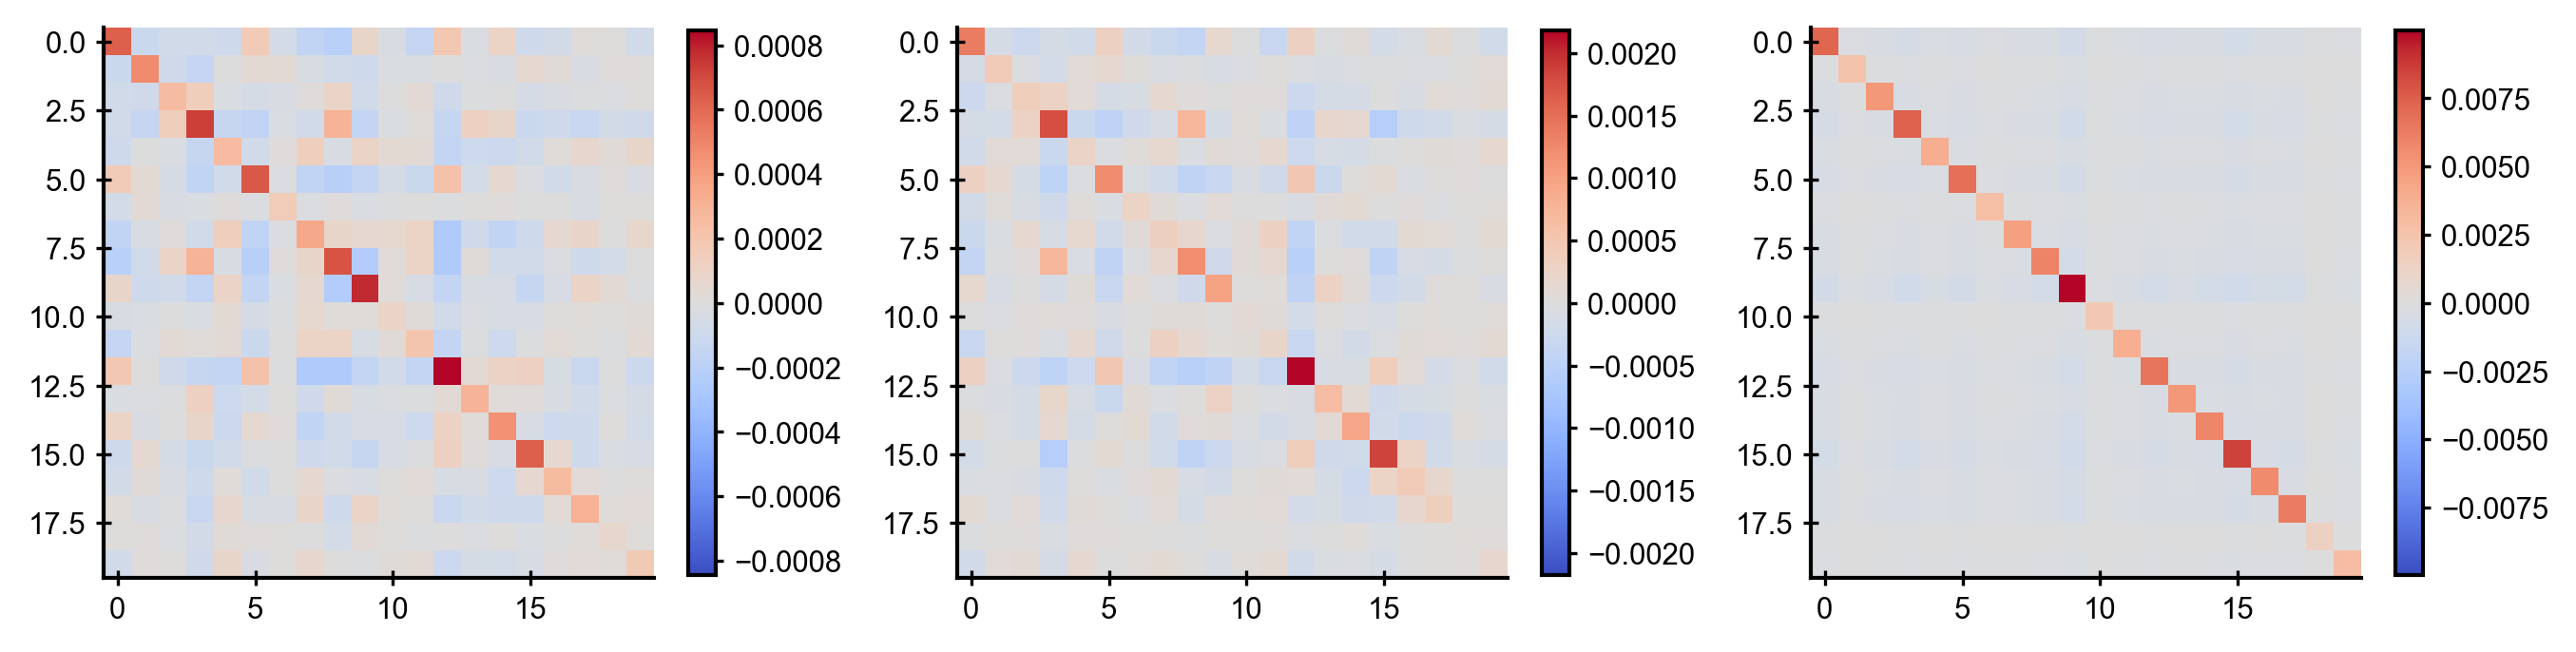

In [10]:
fig, axes = plt.subplots(figsize=(9, 3), ncols=3)
for i, matrix in enumerate([cov_protein, cov_kmer-cov_multinomial, cov_multinomial]):
    ax = axes[i]
    im = ax.imshow(matrix, vmin=-matrix.max(), vmax=matrix.max(), cmap='coolwarm')
    fig.colorbar(im, ax=ax, shrink=0.7)
fig.tight_layout()

0.8384516075175179 1.235956856934011e-159 1.882084253380899


Text(0.05, 1.0, 'slope$=1.88$\n$r^2=0.84$')

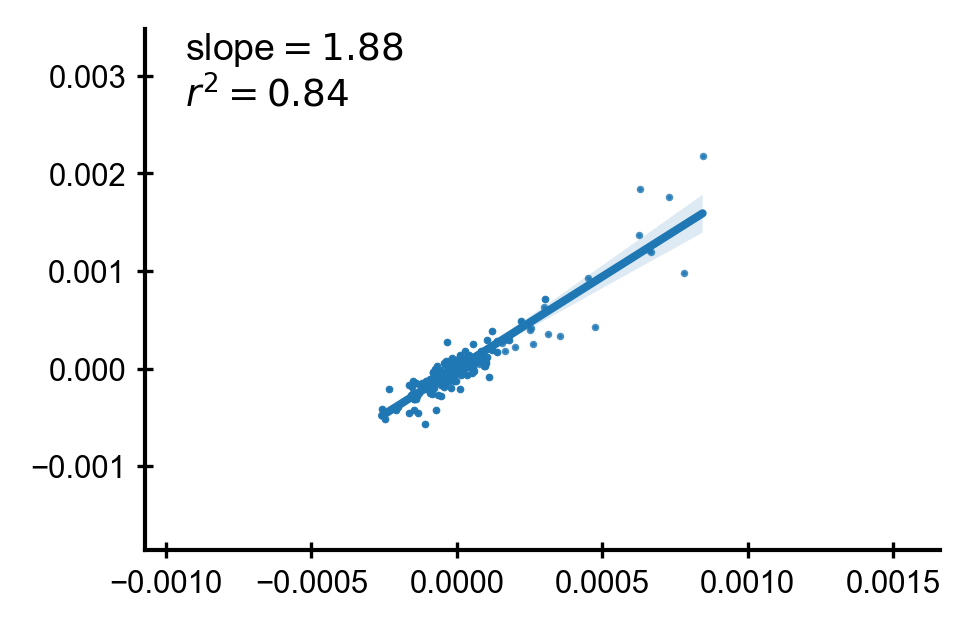

In [11]:
fig, ax = plt.subplots()
x = cov_protein.flatten()
y = (cov_kmer - cov_multinomial).flatten()
sns.regplot(x, y, ax=ax, scatter_kws=dict(s=1))
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
print(r_value**2, p_value, slope)
ax.text(0.05, 1.0, 'slope$={1:.2f}$\n$r^2={0:.2f}$'.format(r_value**2, slope),
        va='top', ha='left', transform=ax.transAxes)

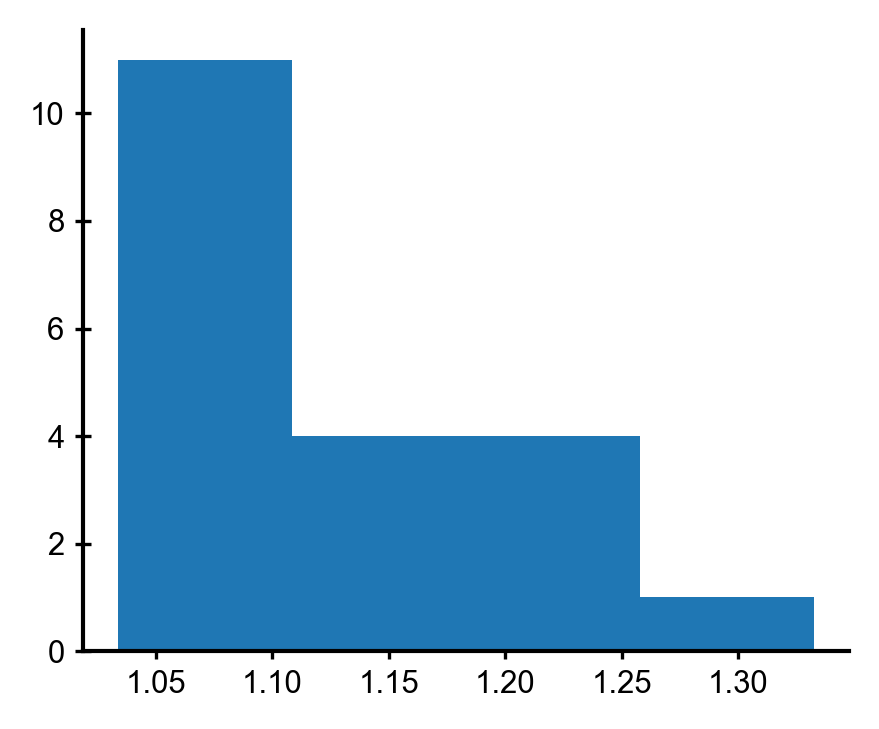

In [12]:
fig, ax = plt.subplots(figsize=(3, 2.5))
ax.hist(np.diag(cov_kmer/cov_multinomial), bins=4)
fig.tight_layout()

# Maxent fitting

In [110]:
def calc_n1(aacounts):
    return np.mean(aacounts, axis=0)

In [111]:
n1 = calc_n1(aacounts)
n1

array([0.62780522, 0.20900568, 0.42814193, 0.63928282, 0.33118047,
       0.59402841, 0.23704755, 0.39269141, 0.51334348, 0.89818893,
       0.17769198, 0.32457545, 0.56641018, 0.42680069, 0.50701989,
       0.75158147, 0.48208344, 0.54131223, 0.10902753, 0.24278126])

In [32]:
@jit(nopython=True)
def calc_n2(matrix, L):
    N, q = matrix.shape
    n2 = np.zeros((q, q))
    for s in range(N):
        for alpha in range(q):
            for beta in range(q):
                n2[alpha, beta] += matrix[s, alpha]*matrix[s, beta]     
    n2 /= N
    return n2

In [33]:
n2 = calc_n2(aacounts, L)

In [18]:
npt.assert_allclose(cov_kmer, (n2 - np.outer(n1, n1))/L**2, atol=1e-8)

In [41]:
@jit(nopython=True)
def energy_cov(x, h, J):
    counts = aacounts_int_jit(x)
    return -(np.sum(h*counts)+np.sum(J*np.outer(counts, counts)))

In [43]:
energy_cov(x0, np.ones(q), np.zeros((q, q)))

-9.0

In [90]:
@jit(nopython=True)
def local_jump_jit(x, q, seed=None):
    if not (seed is None):
        np.random.seed(seed)
    prng = np.random
    xnew = x.copy()
    index = prng.randint(len(x))
    xnew[index] = prng.randint(q)
    return xnew

In [85]:
def fit_cov(n1, n2, L, sampler, q=naminoacids,
            niter=1, epsilon=0.1, pseudocount=1.0,
            prng=None, output=False):
    """ sampler(x0, energy, jump, prng=prng): function returning samples from the distribution """
    if prng is None:
        prng = np.random
    h = np.log(n1/L)
    h -= np.mean(h)
    J = np.zeros_like(n2)
    for iteration in range(niter):
        if output:
            print('iteration %g/%g'%(iteration+1,niter))

        x0 = global_jump(np.zeros(L), q, prng=prng)
        
        def jump(x):
            return local_jump_jit(x, q)
        def energy(x):
            return energy_cov(x, h, J)

        samples = sampler(x0, energy, jump, prng=prng)
        aacounts = to_aacounts(samples)

        n1_model = calc_n1(aacounts)
        n2_model = calc_n2(aacounts, L)
 
        h -= np.log(n1_model/n1)*epsilon
        J -= np.log(n2_model/n2)*epsilon
    return h, J

In [117]:
niter = 50
stepsize = 0.05
nsample = L
nsteps = 2e5
jump = lambda x: local_jump_jit(x, q)
x0 = prng.randint(q, size=L)
output = True

In [121]:
def sampler(*args, **kwargs):
    return mcmcsampler(*args, nsteps=nsteps, nsample=nsample, **kwargs)
h, J = fit_cov(n1, n2, L, sampler=sampler, niter=niter,
                         epsilon=stepsize, prng=prng, output=output)

iteration 1/50
iteration 2/50
iteration 3/50
iteration 4/50
iteration 5/50
iteration 6/50
iteration 7/50
iteration 8/50
iteration 9/50
iteration 10/50
iteration 11/50
iteration 12/50
iteration 13/50
iteration 14/50
iteration 15/50
iteration 16/50
iteration 17/50
iteration 18/50
iteration 19/50
iteration 20/50
iteration 21/50
iteration 22/50
iteration 23/50
iteration 24/50
iteration 25/50
iteration 26/50
iteration 27/50
iteration 28/50
iteration 29/50
iteration 30/50
iteration 31/50
iteration 32/50
iteration 33/50
iteration 34/50
iteration 35/50
iteration 36/50
iteration 37/50
iteration 38/50
iteration 39/50
iteration 40/50
iteration 41/50
iteration 42/50
iteration 43/50
iteration 44/50
iteration 45/50
iteration 46/50
iteration 47/50
iteration 48/50
iteration 49/50
iteration 50/50


In [134]:
nsteps_generate = nsteps*10
model_matrix = mcmcsampler(x0, lambda x: energy_cov(x, h, J), jump,
                           nsteps=nsteps_generate, nsample=nsample, prng=prng)
aacounts_model = to_aacounts(model_matrix)
cov_model = np.cov(aacounts_model.T/L)
n1_model = calc_n1(aacounts_model)

In [123]:
nsteps_generate = nsteps
model_ind = mcmcsampler(x0, lambda x: energy_cov(x, h, np.zeros_like(J)), jump,
                           nsteps=nsteps_generate, nsample=nsample, prng=prng)
aacounts_ind = to_aacounts(model_ind)
cov_ind = np.cov(aacounts_ind.T/L)

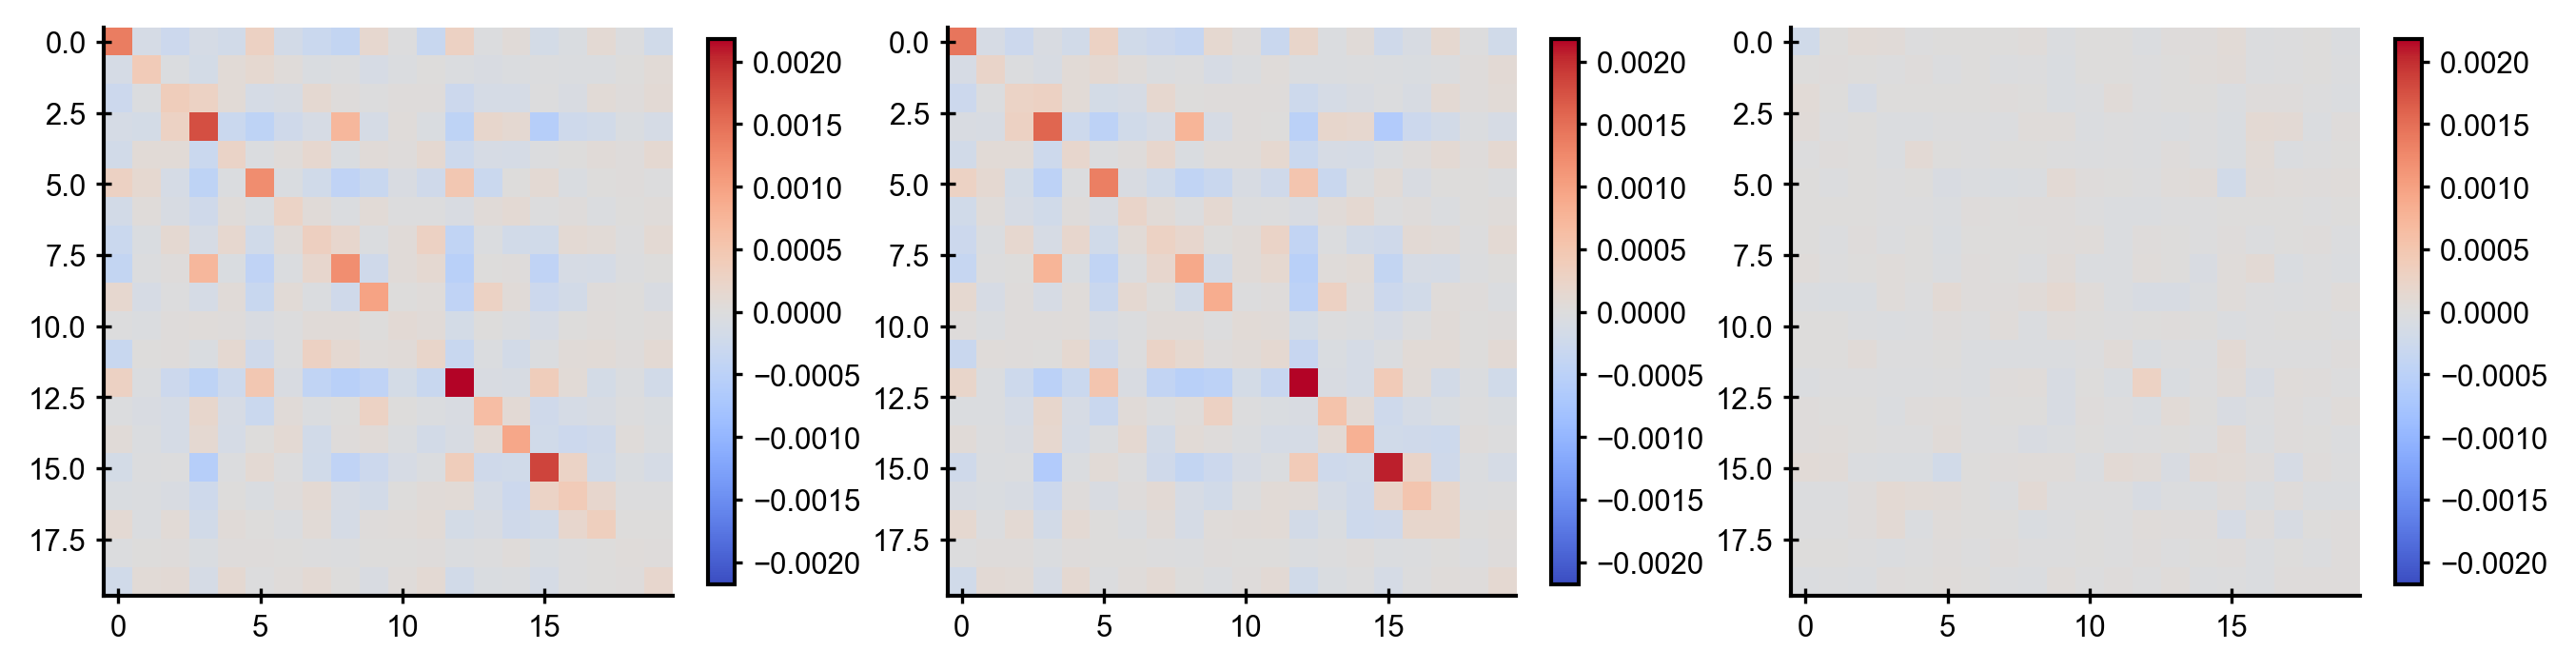

In [135]:
fig, axes = plt.subplots(figsize=(9, 3), ncols=3)
vmax = (cov_kmer-cov_multinomial).max()
for i, matrix in enumerate([cov_kmer-cov_multinomial,
                            cov_model-cov_multinomial,
                            cov_ind-cov_multinomial]):
    ax = axes[i]
    im = ax.imshow(matrix, vmin=-vmax, vmax=vmax, cmap='coolwarm')
    fig.colorbar(im, ax=ax, shrink=0.7)
fig.tight_layout()

0.9816278803346294 0.0 1.0004238411212771


Text(0.05, 1.0, 'slope$=1.00$\n$r^2=0.98$')

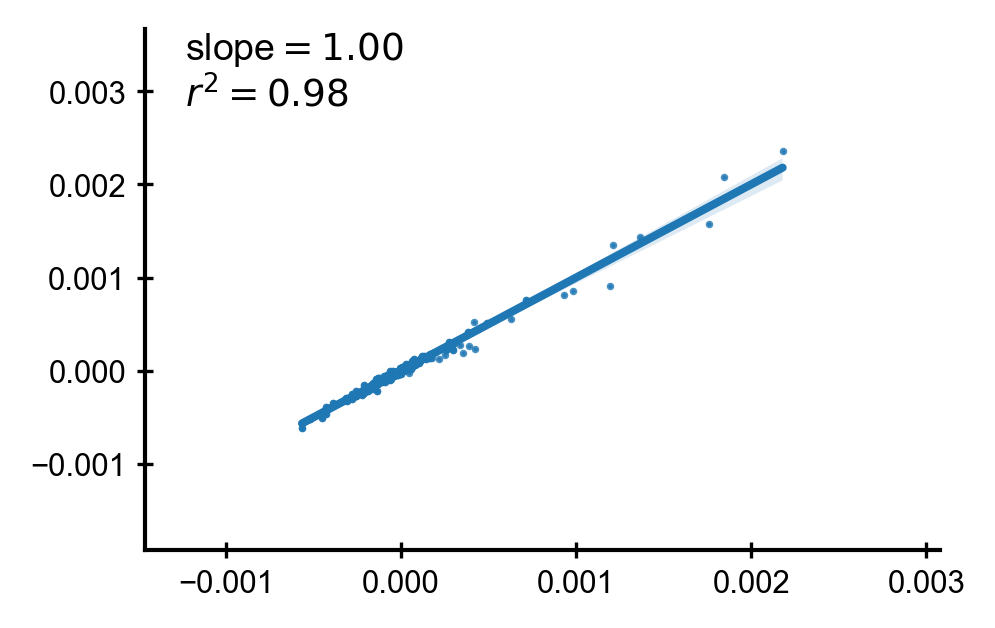

In [136]:
fig, ax = plt.subplots()
x = (cov_kmer-cov_multinomial).flatten()
y = (cov_model-cov_multinomial).flatten()
sns.regplot(x, y, ax=ax, scatter_kws=dict(s=1))
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
print(r_value**2, p_value, slope)
ax.text(0.05, 1.0, 'slope$={1:.2f}$\n$r^2={0:.2f}$'.format(r_value**2, slope),
        va='top', ha='left', transform=ax.transAxes)

0.9985120038111519 6.637161771095654e-27 1.003603653563084


Text(0.05, 1.0, 'slope$=1.00$\n$r^2=1.00$')

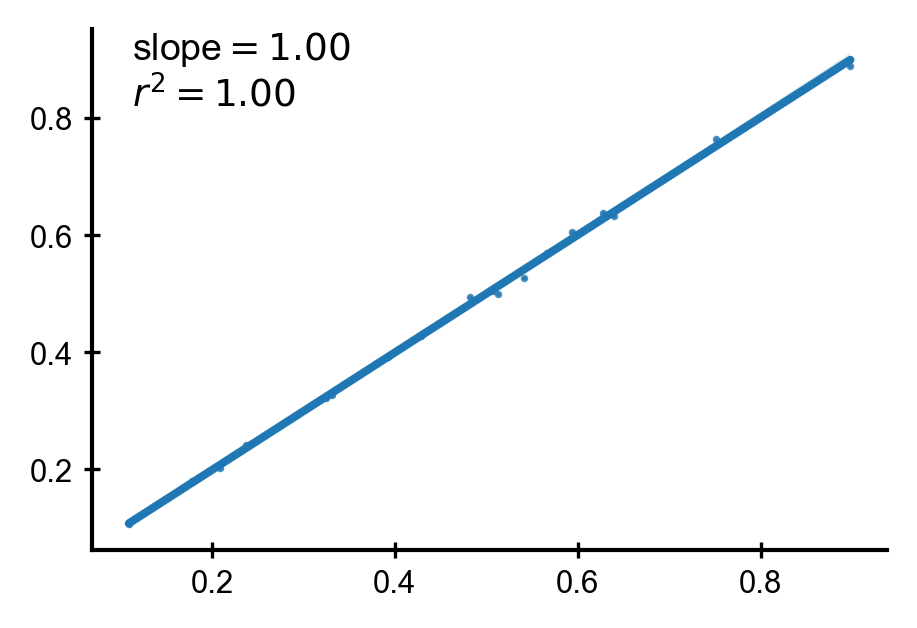

In [137]:
fig, ax = plt.subplots()
x = n1
y = n1_model
sns.regplot(x, y, ax=ax, scatter_kws=dict(s=1))
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
print(r_value**2, p_value, slope)
ax.text(0.05, 1.0, 'slope$={1:.2f}$\n$r^2={0:.2f}$'.format(r_value**2, slope),
        va='top', ha='left', transform=ax.transAxes)